In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [ ]:
class QRDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.loaded_images_count = 0  # Counter for successfully loaded images

    def apply_clahe(self, image_np):
        """Apply CLAHE to a grayscale image."""
        gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(gray)

    def apply_lbp(self, gray_image):
        """Compute Local Binary Pattern (LBP)."""
        lbp = cv2.Laplacian(gray_image, cv2.CV_64F)  # Use Laplacian for LBP-like feature
        return lbp.astype(np.uint8)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            # Load image as numpy array
            image = Image.open(image_path).convert("RGB")
            image_np = np.array(image)

            # Apply CLAHE and LBP
            clahe_image = self.apply_clahe(image_np)
            lbp_image = self.apply_lbp(clahe_image)

            # Stack CLAHE and LBP as 3-channel input
            combined_image = np.stack([clahe_image, lbp_image, lbp_image], axis=-1)

            # Convert back to PIL Image for further transformations
            combined_image = Image.fromarray(combined_image)

            # Apply transformations
            if self.transform:
                combined_image = self.transform(combined_image)

            self.loaded_images_count += 1  # Increment the counter for successfully loaded images
            return combined_image, label

        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return None, None


In [ ]:
def mixup_data(x, y, alpha=0.4):
    """MixUp augmentation."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Criterion for MixUp."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
from google.colab import drive
import os
from sklearn.model_selection import train_test_split

# ===========================
# Mount Google Drive
# ===========================
drive.mount('/content/drive')

# Specify the path to your dataset in Google Drive
data_dir = "/content/drive/My Drive/Colab Notebooks/Computer_Vision_Final_Project"

# ===========================
# Data Preparation Function
# ===========================
def get_data(data_dir):
    """Fetch image paths and labels."""
    image_paths, labels, label_mapping = [], [], {}
    label_counter = 0

    for label_name in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label_name)

        # Check if it's a directory
        if not os.path.isdir(label_dir):
            continue

        # Map label name to numerical index
        if label_name not in label_mapping:
            label_mapping[label_name] = label_counter
            label_counter += 1

        # Collect image paths
        for file in os.listdir(label_dir):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(label_dir, file))
                labels.append(label_mapping[label_name])

    return image_paths, labels

# ===========================
# Load Data
# ===========================
all_image_paths, all_labels = get_data(data_dir)

# ===========================
# Split Data
# ===========================
# Calculate required test size
total_samples = len(all_image_paths)
desired_test_size = 60 / total_samples

# Split the dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=desired_test_size, random_state=42, stratify=all_labels
)


print("Number of training samples:", len(train_paths))
print("Number of testing samples:", len(test_paths))


Mounted at /content/drive
Number of training samples: 502
Number of testing samples: 60


Total images loaded in train dataset: 502
Total images loaded in test dataset: 60


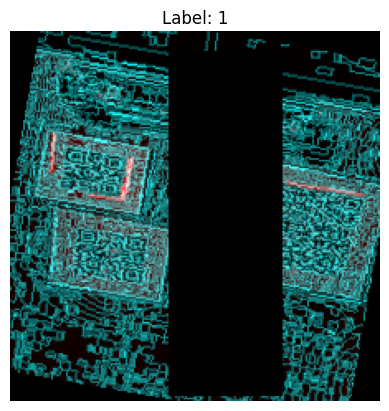

In [ ]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Datasets
train_dataset = QRDataset(train_paths, train_labels, transform=train_transform)
test_dataset = QRDataset(test_paths, test_labels, transform=test_transform)

print(f"Total images loaded in train dataset: {len(train_dataset)}")
print(f"Total images loaded in test dataset: {len(test_dataset)}")

# Visualize Sample Data
sample_image, sample_label = train_dataset[0]
plt.imshow(sample_image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # De-normalize
plt.title(f"Label: {sample_label}")
plt.axis("off")
plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)

# Modify the classifier dynamically
num_features = model.classifier[0].in_features
model.classifier = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(set(train_labels)))
)
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 48.2MB/s]


Epoch 1/20: 100%|██████████| 16/16 [00:07<00:00,  2.03it/s]

Epoch [1], Train Loss: 0.3430, Train Accuracy: 91.95%


Validation Loss: 0.4331, Validation Accuracy: 90.00%


Epoch 2/20: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]

Epoch [2], Train Loss: 0.3617, Train Accuracy: 91.72%


Validation Loss: 0.4437, Validation Accuracy: 90.00%


Epoch 3/20: 100%|██████████| 16/16 [00:09<00:00,  1.78it/s]

Epoch [3], Train Loss: 0.3534, Train Accuracy: 92.42%


Validation Loss: 0.4312, Validation Accuracy: 88.33%


Epoch 4/20: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]

Epoch [4], Train Loss: 0.3609, Train Accuracy: 91.54%


Validation Loss: 0.4098, Validation Accuracy: 90.00%


Epoch 5/20: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]

Epoch [5], Train Loss: 0.3587, Train Accuracy: 90.68%


Validation Loss: 0.4166, Validation Accuracy: 90.00%


Epoch 6/20: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]

Epoch [6], Train Loss: 0.3557, Train Accuracy: 90.79%


Validation Loss: 0.4183, Validation Accuracy: 88.33%


Epoch 7/20: 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]

Epoch [7], Train Loss: 0.3609, Train Accuracy: 91.73%


Validation Loss: 0.4167, Validation Accuracy: 90.00%


Epoch 8/20: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]

Epoch [8], Train Loss: 0.3437, Train Accuracy: 92.15%


Validation Loss: 0.4163, Validation Accuracy: 90.00%


Epoch 9/20: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]

Epoch [9], Train Loss: 0.3581, Train Accuracy: 91.30%


Validation Loss: 0.4161, Validation Accuracy: 90.00%


Epoch 10/20: 100%|██████████| 16/16 [00:05<00:00,  2.73it/s]

Epoch [10], Train Loss: 0.3425, Train Accuracy: 91.67%


Validation Loss: 0.4172, Validation Accuracy: 90.00%


Epoch 11/20: 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]

Epoch [11], Train Loss: 0.3334, Train Accuracy: 93.02%


Validation Loss: 0.4174, Validation Accuracy: 90.00%


Epoch 12/20: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

Epoch [12], Train Loss: 0.3217, Train Accuracy: 92.60%


Validation Loss: 0.4189, Validation Accuracy: 90.00%


Epoch 13/20: 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]

Epoch [13], Train Loss: 0.3464, Train Accuracy: 91.64%


Validation Loss: 0.4202, Validation Accuracy: 90.00%


Epoch 14/20: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]

Epoch [14], Train Loss: 0.3370, Train Accuracy: 92.28%


Validation Loss: 0.4258, Validation Accuracy: 90.00%


Epoch 15/20: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]


Epoch [15], Train Loss: 0.3339, Train Accuracy: 92.49%
Validation Loss: 0.4317, Validation Accuracy: 90.00%


Epoch 16/20: 100%|██████████| 16/16 [00:05<00:00,  2.86it/s]

Epoch [16], Train Loss: 0.3445, Train Accuracy: 92.30%


Validation Loss: 0.4346, Validation Accuracy: 90.00%


Epoch 17/20: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]

Epoch [17], Train Loss: 0.3484, Train Accuracy: 91.66%


Validation Loss: 0.4335, Validation Accuracy: 90.00%


Epoch 18/20: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]

Epoch [18], Train Loss: 0.3336, Train Accuracy: 93.75%


Validation Loss: 0.4456, Validation Accuracy: 85.00%


Epoch 19/20: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]

Epoch [19], Train Loss: 0.3507, Train Accuracy: 91.70%


Validation Loss: 0.4362, Validation Accuracy: 90.00%


Epoch 20/20: 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]

Epoch [20], Train Loss: 0.3275, Train Accuracy: 93.71%


Validation Loss: 0.4735, Validation Accuracy: 88.33%
Final Test Loss: 0.4735
Final Test Accuracy: 88.33%


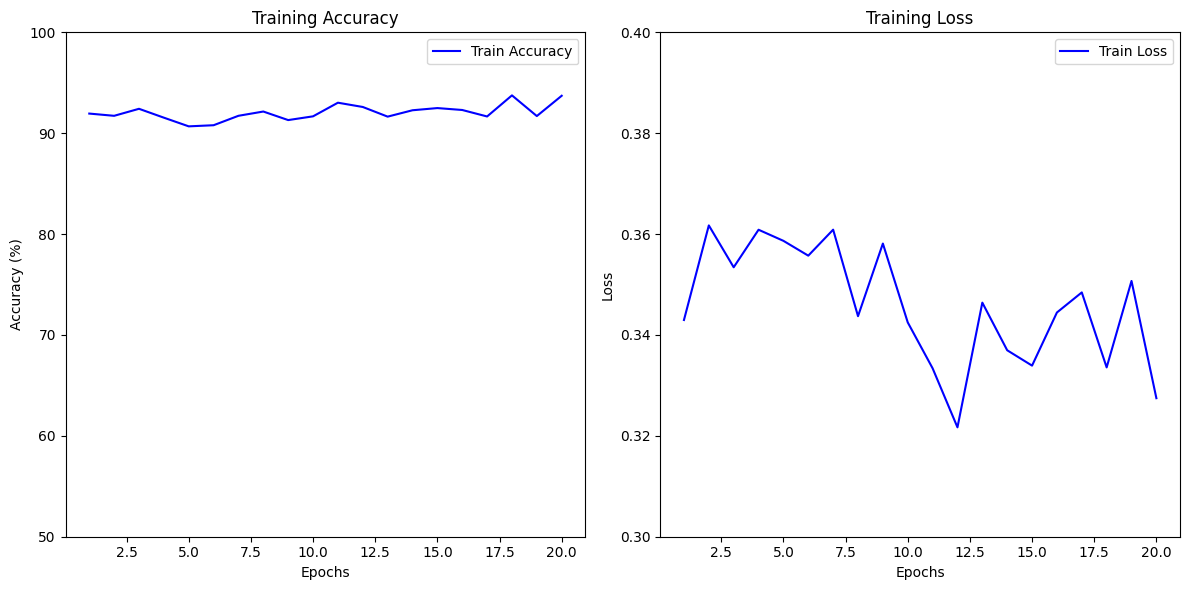

In [14]:
import matplotlib.pyplot as plt
from tqdm import tqdm  # For a progress bar
import torch

# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

if __name__ == '__main__':
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Training Loop
best_acc = 0.0
train_accuracies, test_accuracies = [], []
train_losses, test_losses = [], []

for epoch in range(20):  # Adjust the number of epochs as needed
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    # Training step
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        images, labels = images.to(device), labels.to(device)
        mixed_images, targets_a, targets_b, lam = mixup_data(images, labels)

        optimizer.zero_grad()
        outputs = model(mixed_images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item()
        total += labels.size(0)

    train_acc = 100. * correct / total
    train_loss = running_loss / len(train_loader)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)

    scheduler.step()
    print(f"Epoch [{epoch+1}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

    # Validation step
    model.eval()
    correct_preds = 0
    total_preds = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_preds += labels.size(0)
            correct_preds += (predicted == labels).sum().item()

    val_acc = 100. * correct_preds / total_preds
    val_loss = total_loss / len(test_loader)
    test_accuracies.append(val_acc)
    test_losses.append(val_loss)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

# Final Test Accuracy and Loss
final_test_loss = test_losses[-1]
final_test_accuracy = test_accuracies[-1]
print(f"Final Test Loss: {final_test_loss:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")

# Plot Accuracy and Loss
epochs = range(1, 21)  # Number of epochs

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color="blue")
plt.ylim(50, 100)  # Set y-axis range for accuracy between 50 and 90
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.ylim(0.3, 0.4)  # Set y-axis range for loss between 0.3 and 0.4
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.tight_layout()
plt.show()